# Why the algorithm cannot work with a polynomial number of shots

We denote by $n$ the number of qubits.

We recall the quantities we optimize at each step:

$$\epsilon_{k,0}(\theta) = \left( \frac{|\langle0| U(\theta)^\dagger H U(\theta_{k - 1}) | 0\rangle|}{|b_k|} - 1 \right)^2$$

$$\epsilon_{k,1}(\theta) = |\langle{0 | U(\theta)^\dagger | U(\theta_{k - 1}) | 0}\rangle|^2$$

$$\epsilon_{k,2}(\theta) = |\langle{0 | U(\theta)^\dagger | U(\theta_{k - 2}) | 0}\rangle|^2$$

The general idea for why the algorithm is unlikely to work with a polynomial number of shots is that what we measure is the projector on a single state. Because of that, when we perform the statistical average, we only get two possible result, and getting 1 is extremely (exponentially) unlikely for the vast majority of states, so that in most cases measuring 1 at least once would require an exponential number of shots.

To understand 

### Questions

- Display routine ?
- qatdisplay uses global variables ?
- Why not dictionnary for res ?
- Why not Hadamard in Rk ?
- epsilon1: how can the number of observations to get something different from 0 not scale with the size of the space ?
- epsilon2: can we really neglect the term that looks like epsilon1 ?

### Typos in the documentation

- QRoutine.new_wires: additional (line 7)

In [189]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as q

from scipy.optimize import minimize
from skopt import gp_minimize
from skquant.opt import minimize as qminimize
from skquant.interop.scipy import imfil
from skquant.interop.scipy import snobfit
from skquant.interop.scipy import pybobyqa

from qat.lang.AQASM import *
from qat.core import *
from qat.qpus import get_default_qpu
from qat.fermion.impurity.hamiltonians import make_anderson_model
from qat.fermion.hamiltonians import Hamiltonian
from qat.core.circuit_builder.matrix_util import get_predef_generator

##### Transform to spin Hamiltonian

In [64]:
def transform_to_jw_basis(fermion_hamiltonian):
    """Transform to Jordan-Wigner (JW) basis
    Args:
        fermion_hamiltonian (Hamiltonian or ElectronicStructureHamiltonian): the
            fermionic hamiltonian
    Returns:
        Hamiltonian: the same hamiltonian, in JW spin representation
    """

    nqbits = fermion_hamiltonian.nbqbits
    spin_hamiltonian = Hamiltonian(
        nqbits, [], constant_coeff=fermion_hamiltonian.constant_coeff, do_clean_up=False
    )
    for term in fermion_hamiltonian.terms:
        cur_ham = Hamiltonian(nqbits, [], constant_coeff=term.coeff)
        for op, qb in zip(term.op, term.qbits):
            mini_ham = Hamiltonian(nqbits, [])
            qbits = list(range(qb + 1))

            st = "Z" * (qb) + "X"
            mini_ham.add_term(Term(0.5, st, qbits))

            st = "Z" * (qb) + "Y"
            sign = -1 if op == "C" else 1
            mini_ham.add_term(Term(1j * sign * 0.5, st, qbits))

            cur_ham = cur_ham * mini_ham
        spin_hamiltonian += cur_ham
    spin_hamiltonian.clean_up()
    return spin_hamiltonian

# Hardware efficient ansatz

The parameter $\theta$ has a number of coordinates `n_qubits + n_layers * (2 * n_qubits - 2)`

We assume that `n_qubits` is even

In [65]:
def HEA(n_qubits, n_layers, theta):
        
    routine = QRoutine()
    
    if n_qubits % 2 == 1:
        raise ValueError("The number of qubits should be even")
    
    routine.new_wires(n_qubits)
    
    for k in range(n_qubits):
        routine.apply(RY(theta[k]), k)
    
    for n in range(n_layers):
        
        # First CNOT layer
        for k in range(n_qubits // 2):
            routine.apply(CNOT, 2 * k, 2 * k + 1)
        
        # First RY layer
        for k in range(n_qubits):
            routine.apply(RY(theta[n_qubits + n * (2 * n_qubits - 2) + k]), k)
        
        # Second CNOT layer
        for k in range(n_qubits // 2 - 1):
            routine.apply(CNOT, 2 * k + 1, 2 * k + 2)
        
        # Second RY layer
        for k in range(n_qubits - 2):
            routine.apply(RY(theta[2 * n_qubits + n * (2 * n_qubits - 2) + k]), k + 1)
    
    return routine

##### We take a look at the ansatz and its inverse

In [66]:
n_qubits = 4
n_layers = 2

prog = Program()
reg = prog.qalloc(n_qubits)
U = HEA(n_qubits, n_layers, np.array(range(n_qubits + n_layers * (2 * n_qubits - 2)), float))
U(reg)
U.dag()(reg)

circ = prog.to_circ()

%qatdisplay circ --svg

##### We check that they are indeed the inverse of each other

In [67]:
qpu = get_default_qpu()

job = circ.to_job(nbshots=0)
res = qpu.submit(job)
for sample in res:
    print(sample.state, sample.probability, sample.amplitude)

|0000> 0.9999999999999991 (0.9999999999999996+0j)


# Functions to minimize

### Construction of $\epsilon_1$ and $\epsilon_2$

Since $\epsilon_1$ and $\epsilon_2$ are the same functions for a different theta on the right ($\theta_{n - 1}$ or $\theta_{n - 2}$), we group them in a single function `epsilon12`.

In [68]:
def epsilon12(theta, theta_last, nb_shots, n_qubits, n_layers):
        
    qpu = get_default_qpu()
    
    prog = Program()
    reg = prog.qalloc(n_qubits)
    
    U1 = HEA(n_qubits, n_layers, theta_last)
    U2 = HEA(n_qubits, n_layers, theta)
    
    U1(reg)
    U2.dag()(reg)
    
    circ = prog.to_circ()
        
    job = circ.to_job(nbshots = nb_shots)
    res = qpu.submit(job)
    
    # We look for the probability of 0
    for sample in res:
        if sample._state == 0:
            return sample.probability
    
    return 0

In [69]:
np.random.seed(0)
epsilon12(np.random.rand(100), np.random.rand(100), 100000, 10, 5)

0.0308

### Construction of $\epsilon_0$

We follow the second method: we take a small $\Delta t$, and upon expansion of the exponentatial and Trotterization, we obtain:

$$ | \langle 0 | U(\theta)^\dagger H U(\theta_0) | 0 \rangle | = \frac 1 {\Delta t} | \langle 0 | U(\theta)^\dagger \prod_k e^{-i h_k P_k \Delta t} U(\theta_0) | 0 \rangle | $$

This assumes that $\epsilon_1$ has already been minimized so that we can neglect the 0 order contribution, even after division by the small $\Delta t$.

##### Time evolution under a Pauli matrix

To compute the time evolution under the Hamiltonian, we will need the time evolution under a Pauli matrix:
$$ R_k(\theta) = \exp\left(-i \frac{\theta}{2} P_k\right) $$

In [70]:
"""
Args:
    ops (str): Pauli operators (e.g X, Y, ZZ, etc.)
    qbits (list<int>): qubits on which they act
    theta (Variable): the abstract variable

Returns:
    QRoutine
"""

def Rk(ops, qubits, nb_qubits, theta):
    
    routine = QRoutine()
    
    routine.new_wires(nb_qubits)
    
    with routine.compute():
        for op, qubit in zip(ops, qubits):
            if op == "X":
                routine.apply(H, qubit)
            if op == "Y":
                routine.apply(RX(np.pi/2), qubit)
        for k in range(len(qubits) - 1):
            routine.apply(CNOT, qubits[k], qubits[k + 1])
    
    routine.apply(RZ(theta), qubits[-1])
    
    routine.uncompute()
    
    return routine

##### Example

In [71]:
qubits = [1,3,4]
ops = "XZY"

prog = Program()
reg = prog.qalloc(6)
U = Rk(ops, qubits, 6, 2)
U(reg)

circ = prog.to_circ()

%qatdisplay circ --svg

In [72]:
qpu = get_default_qpu()

job = circ.to_job(nbshots=0)
res = qpu.submit(job)
for sample in res:
    print(sample.state, sample.probability, sample.amplitude)

|000000> 0.2919265817264289 (0.5403023058681398+0j)
|010010> 0.7080734182735712 (0.8414709848078965+0j)


##### Computation of $\epsilon_0$

In [73]:
# We start with the second approach to epsilon0

def epsilon0(theta, theta_last, H, b, nb_shots, n_qubits, n_layers, dt):
    
    qpu = get_default_qpu()
    
    prog = Program()
    reg = prog.qalloc(n_qubits)
    
    U1 = HEA(n_qubits, n_layers, theta_last)
    U2 = HEA(n_qubits, n_layers, theta)
    
    U1(reg)
    
    for term in H.terms:
        Uk = Rk(term.op, term.qbits, n_qubits, 2 * term.coeff * dt)
        Uk(reg)
    
    U2.dag()(reg)
    
    circ = prog.to_circ()
        
    job = circ.to_job(nbshots = nb_shots)
    res = qpu.submit(job)
    
    # We look for the probability of 0
    proba = 0
    for sample in res:
        if sample._state == 0:
            proba = sample.probability
    
    return ((proba**0.5 / (dt * abs(b))) - 1)**2

##### Example

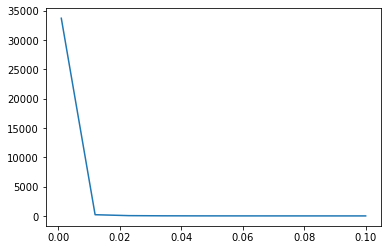

In [74]:
np.random.seed(5)
a1 = np.random.rand(100)
a2 = np.random.rand(100)

# Constructing the Hamiltonian
Ham = transform_to_jw_basis(make_anderson_model(1, 1/2, [1, 2, 3, 4], [-2, -1, 1, 2]))
for term in Ham.terms:
    if np.imag(term.coeff) != 0:
        raise ValueError("Hamiltonian has complex coefficient")
    term.coeff = np.real(term.coeff)

#Ham = Observable(10, pauli_terms=[Term(-0.5, "Z", [i]) for i in range(10)], constant_coeff=10/2)
    
ldt = np.linspace(1e-3, 1e-1, 10)
leps = []

for dt in ldt:
    leps.append(epsilon0(a1, a2, Ham, 1, 0, 10, 5, dt))

plt.plot(ldt, leps)

$\newline$

$\newline$

$\newline$

$\newline$

$\newline$

$\newline$

$\newline$

$\newline$

$\newline$

$\newline$

$\newline$

$\newline$



# Distribution of states after the application of the HEA

Here we look at the distribution of states of $U(\theta)^\dagger U(\theta_0) | 0 \rangle$ for different $\theta_0$ and $\theta$.

We see that as the number of layers increase, the state $|0\rangle$ becomes less and less prefered until it has probability around $\frac 1 {2^n}$

We also check that the distribution of the basis states in the final state roughly correspond to the Porter-Thomas distribution.

Text(0.5, 1.0, '10 qubits and 30 layers')

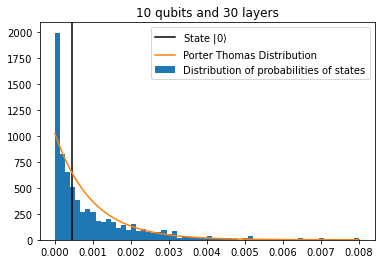

In [14]:
n_qubits = 10
n_layers = 30

#np.random.seed(0)

theta_0 = np.random.rand(1000)
theta = np.random.rand(1000)

qpu = get_default_qpu()

prog = Program()
reg = prog.qalloc(n_qubits)

U1 = HEA(n_qubits, n_layers, theta_0)
U2 = HEA(n_qubits, n_layers, theta)

U1(reg)
U2.dag()(reg)

circ = prog.to_circ()

job = circ.to_job(nbshots = 0)
res = qpu.submit(job)

# Probability of 0
prob0 = 0
for sample in res:
    if sample._state == 0:
        prob0 = sample.probability

plt.axvline(prob0, c = 'k', label = r'State $|0\rangle$')

# The histogram of probabilites
l = [sample.probability for sample in res]
plt.hist(l, bins = 60, density = True, label = 'Distribution of probabilities of states')

# The expected distribution
x = np.linspace(0, max(l), 1000)
plt.plot(x, 2**n_qubits * np.exp(- 2**n_qubits * x), label = "Porter Thomas Distribution")

plt.legend()
plt.title("10 qubits and 30 layers")

We look at what happens when $\theta$ is taken close to $\theta_0$. We take random $\theta$ with a normal distribution centered around $\theta_0$.

In [15]:
theta_0 = np.random.rand(1000)

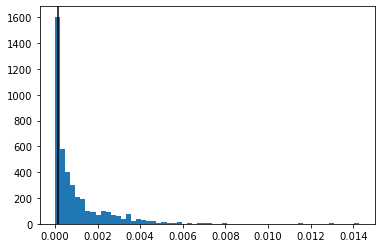

In [16]:
n_qubits = 10
n_layers = 30

#np.random.seed(0)
theta = theta_0 + np.random.normal(scale = 1, size = 1000)

qpu = get_default_qpu()

prog = Program()
reg = prog.qalloc(n_qubits)

U1 = HEA(n_qubits, n_layers, theta_0)
U2 = HEA(n_qubits, n_layers, theta)

U1(reg)
U2.dag()(reg)

circ = prog.to_circ()

job = circ.to_job(nbshots = 0)
res = qpu.submit(job)

# Probability of 0
prob0 = 0
for sample in res:
    if sample._state == 0:
        prob0 = sample.probability

plt.axvline(prob0, c = 'k')

# The histogram of probabilites
l = [sample.probability for sample in res]
plt.hist(l, bins = 60, density = True)

# The expected distribution
x = np.linspace(0, max(l), 1000)
#plt.plot(x, 2**n_qubits * np.exp(- 2**n_qubits * x))

For a given $\theta_0$ and a random $\theta$, we plot the probability of $|0\rangle$ as a function of the average distance between $\theta$ and $\theta_0$:
$$\frac 1 {len(\theta)} ||\theta - \theta_0||^2 $$

In [17]:
n_qubits = 10
n_layers = 20
theta_0 = np.random.rand(n_qubits + n_layers * (2 * n_qubits - 2))

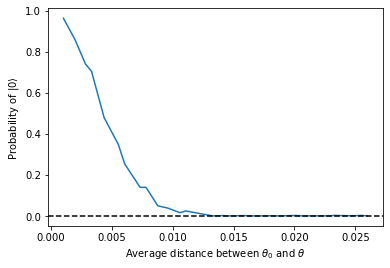

In [18]:
ld = []
lprob = []

#np.random.seed(0)
for sigma in np.linspace(0.02, 0.5, 30):
    
    theta = theta_0 + np.random.normal(scale = sigma, size = n_qubits + n_layers * (2 * n_qubits - 2))

    qpu = get_default_qpu()

    prog = Program()
    reg = prog.qalloc(n_qubits)

    U1 = HEA(n_qubits, n_layers, theta_0)
    U2 = HEA(n_qubits, n_layers, theta)

    U1(reg)
    U2.dag()(reg)

    circ = prog.to_circ()

    job = circ.to_job(nbshots = 0)
    res = qpu.submit(job)

    # Probability of 0
    prob0 = 0
    for sample in res:
        if sample._state == 0:
            prob0 = sample.probability
    
    ld.append(np.linalg.norm(theta - theta_0) / (n_qubits + n_layers * (2 * n_qubits - 2)))
    lprob.append(prob0)

plt.plot(ld, lprob)
plt.axhline(1 / 2**n_qubits, c = 'k', ls = '--')
plt.xlabel(r"Average distance between $\theta_0$ and $\theta$")
plt.ylabel(r"Probability of $|0\rangle$")
print()

### Checking the Hamiltonian

We just check that the Hamiltonian produce with QLM and the one used in the DMFT notebook are indeed the same.

In [75]:
# The description of the Hamiltonian used in the other notebook

def AIM(V, e, U):
    
    # Number of sites in the bath
    nk = len(V)
    
    # Total number of sites
    n = 2 * (nk + 1)
    
    # Defines the fermionic creation operators
    cdags = []
    for k in range(n):
        prod = [q.sigmaz() for x in range(k)] + [q.create(2)] + [q.qeye(2) for x in range(n - k - 1)]
        cdags.append(q.tensor(prod))
    
    # Impurity on-site interaction
    prod = [q.qeye(2) for x in range(n)]
    prod[0] = q.num(2)
    prod[1] = q.num(2)
    H1 = U * q.tensor(prod)
    
    # Impurity chemical potential
    prod = [q.qeye(2) for x in range(n)]
    prod[0] = q.num(2)
    H2 = - (U/2) * q.tensor(prod)
    prod = [q.qeye(2) for x in range(n)]
    prod[1] = q.num(2)
    H2 += - (U/2) * q.tensor(prod)
    
    # Bath energy levels
    H3 = H1 * 0
    for k in range(nk):
        for spin in range(2):
            prod = [q.qeye(2) for x in range(n)]
            prod[2*(k + 1) + spin] = q.num(2)
            H3 += e[k] * q.tensor(prod)
    
    # Bath-impurity interaction
    H4 = H1 * 0
    for k in range(nk):
        for spin in range(2):
            
            H4 += V[k] * cdags[2*(k + 1) + spin] * cdags[spin].dag()
            
            H4 += V[k] * cdags[spin] * cdags[2*(k + 1) + spin].dag()
            
    return H1 + H2 + H3 + H4


# To transform a QLM hamiltonian into a numpy matrix
def make_matrix(hamiltonian):
    mat = np.zeros((2**hamiltonian.nbqbits, 2**hamiltonian.nbqbits), np.complex_)
    mat += np.identity(2**hamiltonian.nbqbits) * hamiltonian.constant_coeff
    for term in hamiltonian.terms:
        op_list = ["I"]*hamiltonian.nbqbits
        for op, qb in zip(term.op, term.qbits):
            op_list[qb] = op
        def mat_func(name): return np.identity(2) if name == "I" else get_predef_generator()[name]
        term_mat = mat_func(op_list[0])
        for op in op_list[1:]:
            term_mat = np.kron(term_mat, mat_func(op))
        mat += term.coeff * term_mat
    return mat

U = 1
V = [3,4]
e = [-5, 5]

H1 = np.array(AIM(V, e, U))
H2 = make_matrix(transform_to_jw_basis(make_anderson_model(U, U/2, V, e)))

np.linalg.norm(H2 - H1)

0.0

# VQE on $\epsilon_1$

We take some random $\theta_0$ and an infinite number of shots, and we try to obtain a $\theta$ such that $\epsilon_1(\theta)$ is exactly 0.

In [195]:
np.random.seed(0)

n_qubits = 4
n_layers = 2
nb_shots = 1000

n_theta = n_qubits + n_layers * (2 * n_qubits - 2)

theta_0 = np.random.rand(n_theta)

l_theta = []
l_val = []

theta_1 = np.random.rand(n_theta)
n_fev = 0

qbounds = np.full((n_theta, 2), np.pi)
qbounds[:,0] = np.full(n_theta, -np.pi)

def callback(x):
    l_theta.append(x)

def gp_callback(res):
    l_theta.append(res.x)
    l_val.append(res.fun)
    
def opti_epsilon(theta):
    n_fev += 1
    print("Number of function evaluation: {}".format(n_fev), end = '\r')
    return epsilon12(theta, theta_0, nb_shots, n_qubits, n_layers)
    
#res = minimize(epsilon12, np.zeros(n_theta), args = (theta_0, nb_shots, n_qubits, n_layers), callback = callback, method = "Powell", options = {'maxiter': 30})
#res = gp_minimize(opti_epsilon, [(-np.pi, np.pi)] * n_theta, callback = gp_callback, n_calls = 30)
#res, hist = qminimize(opti_epsilon, np.zeros(n_theta), qbounds, budget = 30, method = 'imfil')
res = minimize(opti_epsilon, np.zeros(n_theta), bounds = [(-np.pi, np.pi)] * n_theta, callback = callback, method = imfil, options = {'budget': 1000})

In [194]:
res

     fun: 0.0
 message: 'completed'
    nfev: 268
  status: 0
 success: True
       x: array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 3.14159265, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [184]:
qminimize?

In [172]:
epsilon12(res.optpar, theta_0, 0, n_qubits, n_layers)

0.0015986597625649878

In [164]:
hist[]

array([0.11      , 3.14159265, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

Number of iterations: 33

Best value at finite shot: 0.0

Best value with infinite shots: 7.09e-05

Average 0 component of a random vector: 0.0625


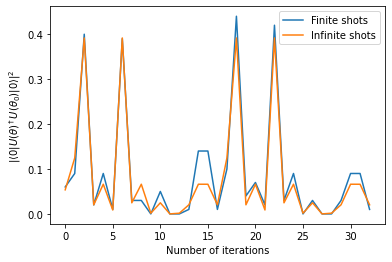

In [180]:
# For qminimize

l_val = [epsilon12(x[1:], theta_0, nb_shots, n_qubits, n_layers) for x in hist]
l_val_inf = [epsilon12(x[1:], theta_0, 0, n_qubits, n_layers) for x in hist]

plt.plot(l_val, label = "Finite shots")
plt.plot(l_val_inf, label = "Infinite shots")
plt.xlabel("Number of iterations")
plt.ylabel(r"$| \langle 0 | U(\theta)^\dagger U(\theta_0) | 0 \rangle |^2$")
plt.legend()

print("Number of iterations: " + str(len(l_val)))
print("\nBest value at finite shot: {:.3}".format(float(min(l_val))))
print("\nBest value with infinite shots: {:.3}".format(float(min(l_val_inf))))
print("\nAverage 0 component of a random vector: {:.3}".format(1 / 2**n_qubits))

In [183]:
np.argmin(l_val_inf)

27

In [181]:
l_val_inf

[0.05359702296228864,
 0.12453753504674112,
 0.39169137808506954,
 0.020297304076754955,
 0.06607575251090865,
 0.008774372236877496,
 0.39169137808506954,
 0.024713325372438026,
 0.06607575251090865,
 0.0015986597625649878,
 0.024713325372438026,
 7.093638040657424e-05,
 0.0015986597625649878,
 0.020297304076754955,
 0.06607575251090865,
 0.06603446049374959,
 0.020297304076754955,
 0.12453753504674112,
 0.39169137808506954,
 0.020297304076754938,
 0.06607575251090865,
 0.00877437223687749,
 0.39169137808506954,
 0.024713325372438043,
 0.06607575251090865,
 0.0015986597625649857,
 0.024713325372438043,
 7.093638040657378e-05,
 0.0015986597625649857,
 0.020297304076754938,
 0.06607575251090865,
 0.06603446049374959,
 0.020297304076754938]

Number of iterations: 30

Final value at finite shot: 0.0

Final value with infinite shots: 5.38e-07

Average 0 component of a random vector: 0.0625


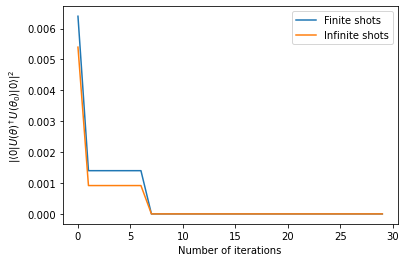

In [79]:
# For gp_minimize and minimize

l_val_inf = [epsilon12(theta, theta_0, 0, n_qubits, n_layers) for theta in l_theta]

plt.plot(l_val, label = "Finite shots")
plt.plot(l_val_inf, label = "Infinite shots")
plt.xlabel("Number of iterations")
plt.ylabel(r"$| \langle 0 | U(\theta)^\dagger U(\theta_0) | 0 \rangle |^2$")
plt.legend()

print("Number of iterations: " + str(len(l_val)))
print("\nFinal value at finite shot: {:.3}".format(float(res.fun)))
print("\nFinal value with infinite shots: {:.3}".format(float(l_val_inf[-1])))
print("\nAverage 0 component of a random vector: {:.3}".format(1 / 2**n_qubits))